In [1]:
from neutromeratio import *
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm

platform = 'cpu'
device = torch.device(platform)
model = torchani.models.ANI1ccx()
model = model.to(device)
torch.set_num_threads(2)

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2

# specify a run number
nr_of_runs = 10
# number of time steps
nr_of_mc_trials = 10

t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']



In [3]:
# generate both rdkit mol
mols = { 't1' : generate_rdkit_mol(t1_smiles), 't2' : generate_rdkit_mol(t2_smiles) }

from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]

ani_input = from_mol_to_ani_input(from_mol)


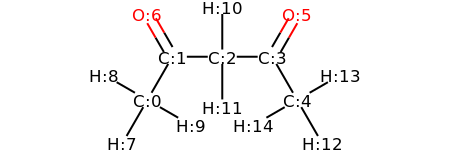

In [4]:
display_mol(mols['t1'])

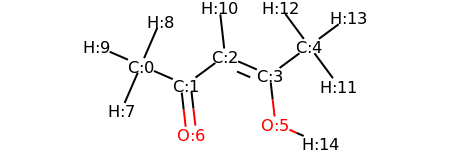

In [5]:
display_mol(mols['t2'])

In [6]:
# extract hydrogen donor idx and hydrogen idx for m2
donor = get_donor_atom_idx(from_mol, to_mol)

# extract hydrogen acceptor idx for to_mol
###################################
###################################
acceptor = 5
###################################
###################################

hydrogen_mover = MC_mover(donor_idx=donor['donor'], hydrogen_idx=donor['hydrogen_idx'], acceptor_idx=acceptor, atom_list=ani_input['atom_list'], energy_function=ANI1ccx_energy)
species = model.species_to_tensor(ani_input['atom_list']).to(device).unsqueeze(0)

# initial conditions: coordinates from example were given in units of angstroms   
x0 = np.array(ani_input['coord_list']) * unit.angstrom
print(f"Hydrogen {hydrogen_mover.hydrogen_idx} is moved from atom-idx {hydrogen_mover.donor_idx} to atom-idx {hydrogen_mover.acceptor_idx}.")
# generating mdtraj traj object
topology = md.load(f"../data/md_sampling/{name}/{name}_t{from_mol_tautomer_idx}.pdb").topology

for run in range(1, nr_of_runs+1):
    print(f"Run Nr: {run}")
    trange = tqdm(range(nr_of_mc_trials))

    traj_in_nm = []
    work_value = []
    
    # initial coordinates
    
    for mc_moves in trange:


        trajectory, final_coordinate_set = langevin(device, model, ani_input['atom_list'], x0, ANI1ccx_force, n_steps=100, stepsize=0.5*unit.femtosecond, temperature=temperature, platform=platform, progress_bar=False)
        traj_in_nm += [x / unit.nanometer for x in trajectory]
        # for debug purpose: write out mol before MC move
        write_xyz_file(hydrogen_mover.atom_list, final_coordinate_set, name=f"{name}_t{from_mol_tautomer_idx}", identifier=f"{run}_{mc_moves}_0_pre_jump")
        # MC move
        new_coordinates, work = hydrogen_mover.perform_mc_move(final_coordinate_set, model, species, device)
        work_value.append(work)
        # for debug purpose: write out mol after MC move
        write_xyz_file(hydrogen_mover.atom_list, new_coordinates, name=f"{name}_t{from_mol_tautomer_idx}", identifier=f"{run}_{mc_moves}_1_post_jump")
        # update new coordinates for langevin dynamics
        x0 = final_coordinate_set
        
        
    ani_traj = md.Trajectory(traj_in_nm, topology)
    ani_traj.save(f"../data/md_mc_sampling/{name}/{name}_t{from_mol_tautomer_idx}_run{run}_anicxx.dcd")

    f = open(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_run{run}_work.csv", 'w+')
    for i, j in zip(range(nr_of_mc_trials), work_value):
        f.write('{}, {}\n'.format(i, j))
    f.close()
        

  0%|          | 0/10 [00:00<?, ?it/s]

m1: Index of atom that moves: 11.
Hydrogen 11 is moved from atom-idx 2 to atom-idx 5.
Run Nr: 1


  0%|          | 0/10 [00:00<?, ?it/s]

Run Nr: 2


  0%|          | 0/10 [00:00<?, ?it/s]

Run Nr: 3


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

KeyboardInterrupt: 